# Signal Processing in Practice Laboratory

**Assignment 3: Graph Machine Learning**




**Submission instructions:**


*   **Make a copy of the Colab .ipynb file** and **share the link in Teams** as instructed.
* Use text cells to answer. Type equations in Latex in a text cell.
* For the programming part the homework, use code cell and text cell. The submitted codes should compile without any errors and do not erase the outputs.

In [ ]:
# Name: BHaskar Karol
# SR number: 24076

**Graph Neural Networks (GNNs) for the task of node classification**.

In this assignment, we will implement graph convolution neural networks from Pytorch geometric toolbox.

In node classification, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).





In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.6 MB/s eta 0:00:00



We make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


## Training a Graph Neural Network (GNN)

Now implement a GNN using PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):

    def __init__(self, hidden_channels):
        super().__init__()
        #torch.manual_seed(1234567)
        self.layer1 = GCNConv(dataset.num_features, 4)
        self.layer2 = GCNConv(4, 4)
        self.layer3 = GCNConv(4, 2)
        self.layer4 = GCNConv(2, dataset.num_classes)

    def forward(self, node_feats, edge_list):
        x = self.layer1(node_feats, edge_list).tanh()
        x = self.layer2(x, edge_list).tanh()
        x = self.layer3(x, edge_list).tanh()
        output = self.layer4(x, edge_list)
        return output




model = GCN(hidden_channels=20)
print(model)


GCN(
  (layer1): GCNConv(1433, 4)
  (layer2): GCNConv(4, 4)
  (layer3): GCNConv(4, 2)
  (layer4): GCNConv(2, 7)
)


Report the training and test accuracies as described next

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=20)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9442
Epoch: 002, Loss: 1.9378
Epoch: 003, Loss: 1.9289
Epoch: 004, Loss: 1.9205
Epoch: 005, Loss: 1.9118
Epoch: 006, Loss: 1.9017
Epoch: 007, Loss: 1.8911
Epoch: 008, Loss: 1.8804
Epoch: 009, Loss: 1.8687
Epoch: 010, Loss: 1.8560
Epoch: 011, Loss: 1.8431
Epoch: 012, Loss: 1.8296
Epoch: 013, Loss: 1.8152
Epoch: 014, Loss: 1.8005
Epoch: 015, Loss: 1.7856
Epoch: 016, Loss: 1.7699
Epoch: 017, Loss: 1.7539
Epoch: 018, Loss: 1.7378
Epoch: 019, Loss: 1.7212
Epoch: 020, Loss: 1.7045
Epoch: 021, Loss: 1.6879
Epoch: 022, Loss: 1.6711
Epoch: 023, Loss: 1.6543
Epoch: 024, Loss: 1.6377
Epoch: 025, Loss: 1.6210
Epoch: 026, Loss: 1.6047
Epoch: 027, Loss: 1.5885
Epoch: 028, Loss: 1.5725
Epoch: 029, Loss: 1.5568
Epoch: 030, Loss: 1.5412
Epoch: 031, Loss: 1.5261
Epoch: 032, Loss: 1.5111
Epoch: 033, Loss: 1.4965
Epoch: 034, Loss: 1.4821
Epoch: 035, Loss: 1.4679
Epoch: 036, Loss: 1.4539
Epoch: 037, Loss: 1.4400
Epoch: 038, Loss: 1.4264
Epoch: 039, Loss: 1.4128
Epoch: 040, Loss: 1.3993


Let us check the test accuracy

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6150


**Visualization of the embeddings**

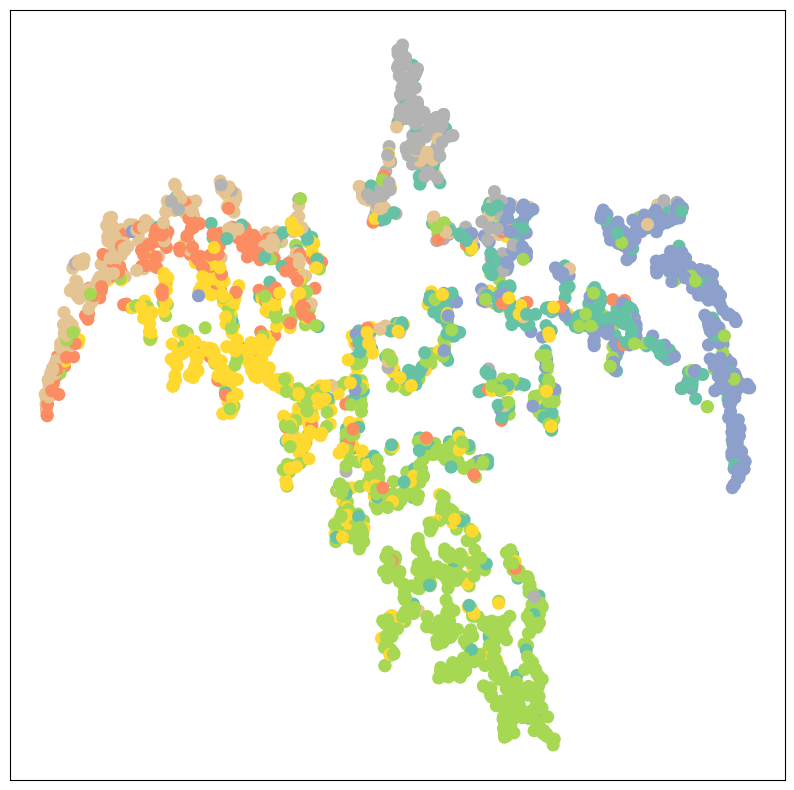

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)